<a href="https://colab.research.google.com/github/bwr02/ECE180-Final/blob/eshan-68%25/ECE180_Final_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 180 Final Project
This is the official notebook that we will present. Please keep it nice and clean.

## Task
- 30 kinds of balls

## Model Architecture
- TBD

## Group members
- Barry Wang
- Ben Richardson
- Allan Garcia
-
-
-

In [1]:
# Generic Data Handling
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# PyTorch Basic Needs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Add other stuff as we go
import random

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


#Data Importing and Preprocessing
Import the dataset and group into training, validation, and testing groups. We may need to do cross validation.

In [2]:
# Data importing
!pip install kaggle # Install Kaggle API

In [3]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"allgar","key":"24a4520df8ec60b3365874ac903b1e1f"}'}

In [4]:
# Download the Dataset

# Create a directory for Kaggle and move the API key there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Use Kaggle API to download the dataset
!kaggle datasets download -d gpiosenka/balls-image-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/balls-image-classification
License(s): CC0-1.0
 95% 137M/144M [00:02<00:00, 82.1MB/s]
100% 144M/144M [00:02<00:00, 65.2MB/s]


In [5]:
# Extract the Dataset

# Unzip the dataset
!unzip balls-image-classification.zip -d balls_image_classification

Archive:  balls-image-classification.zip
  inflating: balls_image_classification/EfficientNetB0 model-30-(224 X 224)- 99.33.h5  
  inflating: balls_image_classification/balls.csv  
  inflating: balls_image_classification/test/baseball/1.jpg  
  inflating: balls_image_classification/test/baseball/2.jpg  
  inflating: balls_image_classification/test/baseball/3.jpg  
  inflating: balls_image_classification/test/baseball/4.jpg  
  inflating: balls_image_classification/test/baseball/5.jpg  
  inflating: balls_image_classification/test/basketball/1.jpg  
  inflating: balls_image_classification/test/basketball/2.jpg  
  inflating: balls_image_classification/test/basketball/3.jpg  
  inflating: balls_image_classification/test/basketball/4.jpg  
  inflating: balls_image_classification/test/basketball/5.jpg  
  inflating: balls_image_classification/test/beachballs/1.jpg  
  inflating: balls_image_classification/test/beachballs/2.jpg  
  inflating: balls_image_classification/test/beachballs/3.jpg

In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='balls_image_classification/train', transform=transform)
val_dataset = datasets.ImageFolder(root='balls_image_classification/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='balls_image_classification/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Visualize data set after the import to ensure correct classifcation of files before training.
If data is normalized it needs be to denormalized before this function (or run before it occurs)

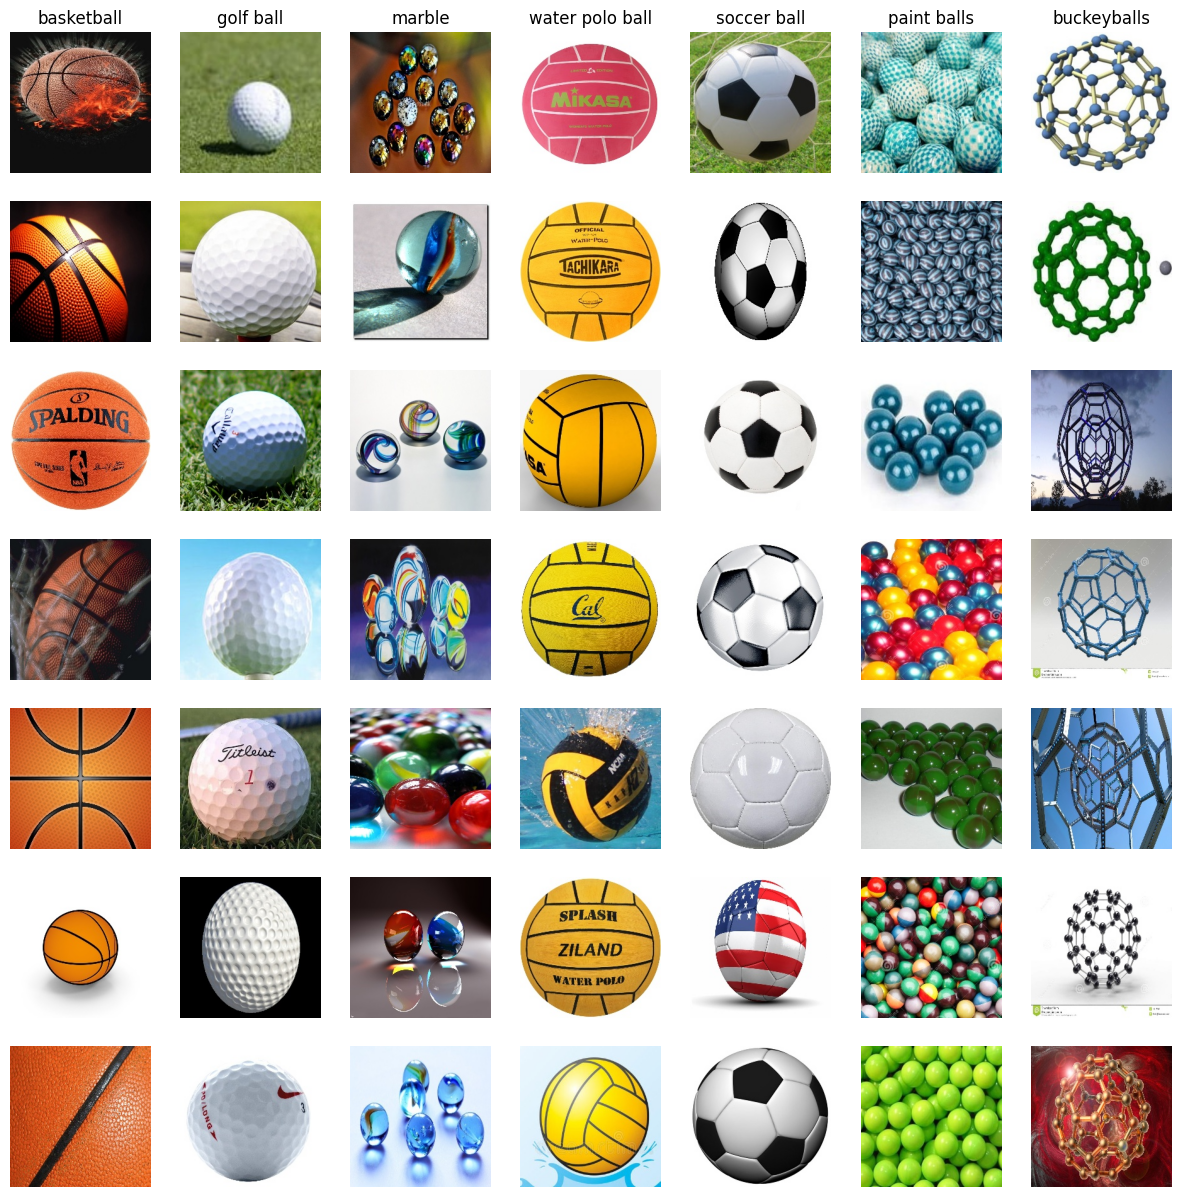

In [7]:
# Function to show images
def imshow(img, title):
    img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Function to visualize dataset
def visualize_dataset(dataset, classes, samples_per_class=7, num_classes_to_display=7):
    selected_classes = random.sample(classes, num_classes_to_display)
    selected_class_indices = [classes.index(cls) for cls in selected_classes]

    num_classes = len(selected_classes)
    fig = plt.figure(figsize=(15, 15))

    for y, cls in enumerate(selected_classes):
        class_indices = [i for i, (img, label) in enumerate(dataset) if label == selected_class_indices[y]]
        selected_indices = random.sample(class_indices, samples_per_class)

        for i, idx in enumerate(selected_indices):
            img, label = dataset[idx]
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            imshow(img, cls if i == 0 else '')

    plt.show()

# Get class names
classes = train_dataset.classes

# Visualize the training dataset
visualize_dataset(train_dataset, classes, samples_per_class=7, num_classes_to_display=7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defining the Model
Define and compile a CNN model

In [8]:
# Input size is 3 * 224 * 224
class BallClassifierCNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(BallClassifierCNN, self).__init__()
        # Drop out every other layer
        # Pooling in forward
        # 3 * 224 * 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # 64 * 112 * 112
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn2 = nn.BatchNorm2d(128)
        # 128 * 56 * 56
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        # 256 * 28 * 28
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.bn4 = nn.BatchNorm2d(512)
        # 512 * 14 * 14
        # log this FC input size
        self.fc_input_size = 512 * 14 * 14
        self.fc1 = nn.Linear(self.fc_input_size, 1024)
        # 1 * 1024
        self.fc2 = nn.Linear(1024, 512)
        # 1 * 512
        self.fc3 = nn.Linear(512, 30)
        # 1 * 30 output

        # Each pooling layer reduces size by factor of 4
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 224 -> 112
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 112 -> 56
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 56 -> 28
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 28 -> 14

        x = x.view(-1, self.fc_input_size)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [9]:
model = BallClassifierCNN().to(device)

criterion = nn.CrossEntropyLoss()


Some notes:
For the first 40 or 60 epochs, lr=0.001 is ok. Somewhere around 50 epochs is when the loss will seemingly stop decreasing.

In [11]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop (moved this to a new block so training progress is not reset by re-initializing 'model')
num_epochs = 20
size = len(train_loader.dataset)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    learning_rate -= learning_rate/10 #adjust learning rate
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("Training complete.")

Epoch [1/20], Loss: 2.587433152494177
Epoch [2/20], Loss: 2.363528394066127
Epoch [3/20], Loss: 2.153566393177066
Epoch [4/20], Loss: 1.960452462719605
Epoch [5/20], Loss: 1.802653252550986
Epoch [6/20], Loss: 1.7186262902960312
Epoch [7/20], Loss: 1.5480738909898606
Epoch [8/20], Loss: 1.4319426580867936
Epoch [9/20], Loss: 1.3356763615017444
Epoch [10/20], Loss: 1.2255421196464944
Epoch [11/20], Loss: 1.1480795978444867
Epoch [12/20], Loss: 1.06358648506941
Epoch [13/20], Loss: 1.0171652995379625
Epoch [14/20], Loss: 0.9710164745297052
Epoch [15/20], Loss: 0.8856730247493338
Epoch [16/20], Loss: 0.8489522725607441
Epoch [17/20], Loss: 0.8044041782881306
Epoch [18/20], Loss: 0.7477552305280635
Epoch [19/20], Loss: 0.7362525550137579
Epoch [20/20], Loss: 0.6647117644284679
Training complete.


In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 68.0%, Avg loss: 1.160050 



#Training
Train the model and find the best hyperparams. Let's try to automate this.

In [ ]:
# Have a trainer class that will work on one or a set of models and return the
# best model. Make it so that it can save its progress to a file every defined
# interval.

class Trainer(object):
  def __init__(self, ...):
    pass

  def train(self, ...):
    pass

  def save(self, ...):
    pass

  def recover(self, ...):
    pass


In [ ]:
trainer = Trainer(...)
result = trainer.train(...)

# Testing
Test the model and show test results

In [ ]:
def test(model, img_test, label_test):
  pass